In [1]:
%matplotlib inline


# Multi-metric evaluation on cross_val_score and GridSearchCV


Multiple metric parameter search can be done by setting the ``scoring``
parameter to a list of metric scorer names or a dict mapping the scorer names
to the scorer callables.

The scores of all the scorers are available in the ``cv_results_`` dict at keys
ending in ``'_<scorer_name>'`` (``'mean_test_precision'``,
``'rank_test_precision'``, etc...)

The ``best_estimator_``, ``best_index_``, ``best_score_`` and ``best_params_``
correspond to the scorer (key) that is set to the ``refit`` attribute.



In [2]:

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

print(__doc__)
print("If this exeutes it is Python 3")

Automatically created module for IPython interactive environment


Running ``GridSearchCV`` using multiple evaluation metrics
----------------------------------------------------------




In [3]:
X, y = make_hastie_10_2(n_samples=8000, random_state=42)

# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_parameters_`` and
# ``gs.best_index_``
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 403, 10)},
                  scoring=scoring, cv=5, refit='AUC')
gs.fit(X, y)
results = gs.cv_results_

Plotting the result
-------------------



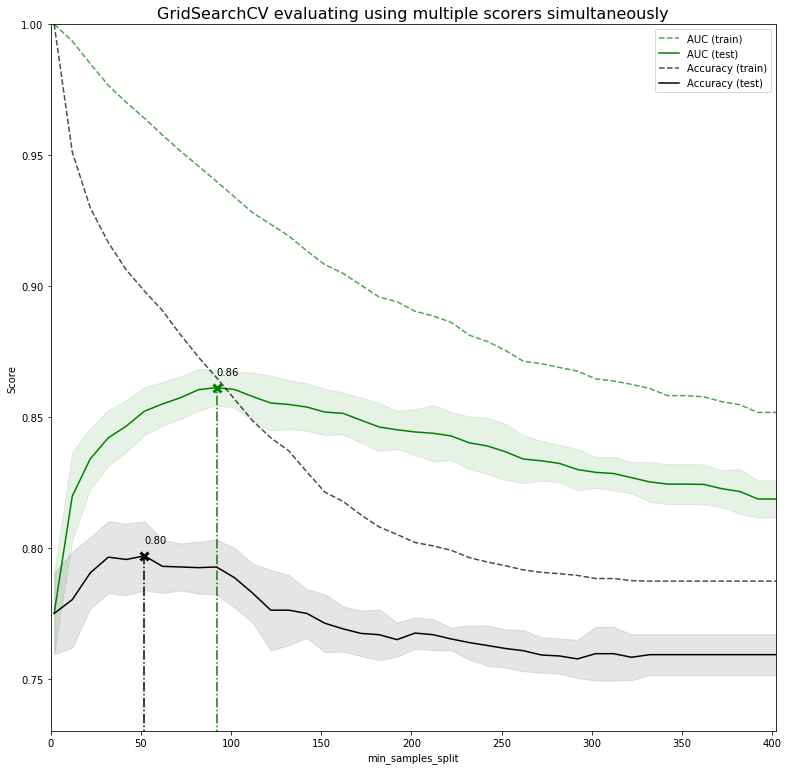

In [4]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()